In [1]:
import glob
import os

import pandas as pd

### Functions to group predictions and ground truth annotations (if same specie and overlapping times)

In [2]:
def group_consecutive_predictions_birdnet(predictions_df):
    grouped_predictions = []
    current_group = []
    last_end = None
    for _, row in predictions_df.iterrows():
        if current_group and (row['Start (s)'] != last_end or row['Scientific name'] != current_group[-1]['Scientific name']):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['End (s)']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)
    # Combine groups in unique predictions
    combined_predictions = []
    for group in grouped_predictions:
        combined_prediction = {
            'Start (s)': group[0]['Start (s)'],
            'End (s)': group[-1]['End (s)'],
            'Scientific name': group[0]['Scientific name'],
            'Confidence': max(item['Confidence'] for item in group)  # conf = max confidence in group
        }
        combined_predictions.append(combined_prediction)
    return combined_predictions

def group_consecutive_annotations_gt(annotations_df):
    annotations_df.sort_values(by=['path', 'specie', 'start_time'], inplace=True)
    grouped_predictions = []
    current_group = []
    last_end = None
    last_path = None
    last_specie = None

    for _, row in annotations_df.iterrows():
        if current_group and (row['path'] != last_path or row['specie'] != last_specie or row['start_time'] - last_end >= 2):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['end_time']
        last_path = row['path']
        last_specie = row['specie']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)

    # Combine groups into unique predictions
    combined_annotations = []
    for group in grouped_predictions:
        combined_prediction = {
            'path': group[0]['path'],
            'start_time': group[0]['start_time'],
            'end_time': group[-1]['end_time'],
            'specie': group[0]['specie'],
        }
        combined_annotations.append(combined_prediction)
    
    return combined_annotations

### Auxiliar Functions

In [3]:
# Function to calculate the IoU
def calculate_iou(interval1, interval2):
    start_max = max(interval1[0], interval2[0])
    end_min = min(interval1[1], interval2[1])
    intersection = max(0, end_min - start_max)
    union = (interval1[1] - interval1[0]) + (interval2[1] - interval2[0]) - intersection
    return intersection / union if union != 0 else 0

In [6]:
def is_detection_birdnet(gt_row, grouped_predictions, confidence_threshold, iou_threshold=0):
    for prediction in grouped_predictions:
        if prediction['Confidence'] >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if iou >= iou_threshold:
                return True
    return False

In [7]:
def display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives):
    print("================== Metrics ==================\n")
    print(f"Total Predictions: {total_predictions}")
    print(f"Total Predictions with Score >= {prediction_conf_score}: {total_predictions_score}")
    print(f"Total GT: {total_gt}")
    print(f"Correct Predictions Detector: {true_positives_detector}")
    print(f"Correct Predictions Detector + Classifier: {correct_predictions}")

    # Additional calculations for precision, recall, and F1-score
    print("\n================== Detector Metrics ==================\n")

    # Calculate and display the metrics
    accuracy_detector = (true_positives_detector + true_negatives) / (true_positives_detector + true_negatives + false_positives + false_negatives_detector) if true_positives_detector + true_negatives + false_positives + false_negatives_detector != 0 else 0
    precision_detector = true_positives_detector / (true_positives_detector + false_positives) if true_positives_detector + false_positives != 0 else 0
    recall_detector = true_positives_detector / (true_positives_detector + false_negatives_detector) if true_positives_detector + false_negatives_detector != 0 else 0
    f1_score_detector = 2 * precision_detector * recall_detector / (precision_detector + recall_detector) if precision_detector + recall_detector != 0 else 0
    print(f"Accuracy: {accuracy_detector}")
    print(f"Precision: {precision_detector}")
    print(f"Recall: {recall_detector}")
    print(f"F1-Score: {f1_score_detector}")

    print("\n================== Detector + Classifier Metrics ==================\n")

    # Calculate and display the metrics
    accuracy_classifier = (true_positives_classifier + true_negatives) / (true_positives_classifier + true_negatives + false_positives + false_negatives_detector) if true_positives_classifier + true_negatives + false_positives + false_negatives_classifier != 0 else 0
    precision_classifier = true_positives_classifier / (true_positives_classifier + false_positives) if true_positives_classifier + false_positives != 0 else 0
    recall_classifier = true_positives_classifier / (true_positives_classifier + false_negatives_detector) if true_positives_classifier + false_negatives_detector != 0 else 0
    f1_score_classifier = 2 * precision_classifier * recall_classifier / (precision_classifier + recall_classifier) if precision_classifier + recall_classifier != 0 else 0
    print(f"Accuracy: {accuracy_classifier}")
    print(f"Precision: {precision_classifier}")
    print(f"Recall: {recall_classifier}")
    print(f"F1-Score: {f1_score_classifier}")

    print("\n================== Other ==================\n")
    print(f"False Positives: {false_positives}")

def analyze_predictions_BirdNET(gt_df, analysis_name, prediction_conf_score=0.6, iou_threshold=0.1):
    # Variables for metrics
    correct_predictions = 0
    total_predictions = 0
    total_predictions_score = 0

    total_gt = len(gt_df)

    # Metrics
    true_positives_detector = 0
    true_positives_classifier = 0
    false_positives = 0
    false_negatives_detector = 0
    false_negatives_classifier = 0
    true_negatives = 0

    last_file = None

    # Process the predictions
    for _, gt_annotation in gt_df.iterrows():
        # Load the predictions
        prediction_path = f"../BirdNET/Predictions/{analysis_name}/{gt_annotation['path'].replace('.WAV', '.BirdNET.results.csv')}"

        current_file = gt_annotation['path']

        try:
            predictions_df = pd.read_csv(prediction_path)
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)  # Group predictions

            if current_file != last_file:
                total_predictions += len(grouped_predictions)
                current_predictions_score = len([p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score])
                total_predictions_score += current_predictions_score

            # If the annotation if not a background
            if gt_annotation['specie'] != 'No audio':
                # Check if the GT is detected by the detector
                if is_detection_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    true_positives_detector += 1
                else:
                    false_negatives_detector += 1
                
                if is_detection_classification_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    correct_predictions += 1
                    true_positives_classifier += 1
                else:
                    false_negatives_classifier += 1
            else: # Annotation is a background
                # Take only grouped_predictions with confidence >= prediction_conf_score
                if current_predictions_score == 0:
                    true_negatives += 1
                else: # Background is unique file, with no annotations, so all predictions on that file are false positives
                    false_positives += current_predictions_score

            last_file = current_file

        except FileNotFoundError:
            print(f"Prediction file not found: {prediction_path}")

    # Calculate and display the metrics
    display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives)

In [8]:
def analyze_predictions_YOLO_BirdNET(gt_df, analysis_name, prediction_conf_score=0.6, iou_threshold=0.1):
    # Variables for metrics
    correct_predictions = 0
    total_predictions = 0
    total_predictions_score = 0
    total_gt = len(gt_df)
    # Metrics
    true_positives_detector = 0
    true_positives_classifier = 0
    false_positives = 0
    false_negatives_detector = 0
    false_negatives_classifier = 0
    true_negatives = 0

    last_file = None

    # Process the predictions
    for _, gt_annotation in gt_df.iterrows():
        gt_basename = gt_annotation['path'].split('/')[-1]
        gt_basename_no_ext = os.path.splitext(gt_basename)[0]
        # Assuming the structure of the file name is consistent with the example given
        prediction_files = os.listdir(f"../BirdNET/Predictions/{analysis_name}")
        prediction_files_filtered = [file for file in prediction_files if file.startswith(gt_basename_no_ext)]

        current_file = gt_annotation['path']
        
        # predictions_df initialization
        predictions_df = pd.DataFrame(columns=['Start (s)', 'End (s)', 'Scientific name', 'Common name', 'Confidence'])

        for prediction_file in prediction_files_filtered:
            start_time, end_time = prediction_file.split('_')[-2:]
            end_time = end_time.split('.BirdNET')[0]
            start_time = float(start_time)
            end_time = float(end_time)
            prediction_path = f"../BirdNET/Predictions/{analysis_name}/{prediction_file}"

            # Create prediction DataFrame and append all of current prediction file
            current_prediction_df = pd.read_csv(prediction_path)

            # Set start and end times
            current_prediction_df['Start (s)'] = float(start_time)
            current_prediction_df['End (s)'] = float(end_time)

            # If current_prediction_df is not empty, concatenate it to predictions_df
            if not current_prediction_df.empty:
                if predictions_df.empty:
                    predictions_df = current_prediction_df
                else:
                    predictions_df = pd.concat([predictions_df, current_prediction_df], ignore_index=True)

        grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)  # Group predictions
        
        try:
            if current_file != last_file:
                total_predictions += len(grouped_predictions)
                current_predictions_score = len([p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score])
                total_predictions_score += current_predictions_score
            # If the annotation if not a background
            if gt_annotation['specie'] != 'No audio':
                # Check if the GT is detected by the detector
                if is_detection_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    true_positives_detector += 1
                else:
                    false_negatives_detector += 1
                
                if is_detection_classification_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    correct_predictions += 1
                    true_positives_classifier += 1
                else:
                    false_negatives_classifier += 1
            else: # Annotation is a background
                # Take only grouped_predictions with confidence >= prediction_conf_score
                if current_predictions_score == 0:
                    true_negatives += 1
                else: # Background is unique file, with no annotations, so all predictions on that file are false positives
                    false_positives += current_predictions_score
            
            last_file = current_file

        except FileNotFoundError:
            print(f"Prediction file not found: {prediction_path}")

    # Calculate and display the metrics
    display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives)

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives):
    print("================== Metrics ==================\n")
    print(f"Total Predictions: {total_predictions}")
    print(f"Total Predictions with Score >= {prediction_conf_score}: {total_predictions_score}")
    print(f"Total GT: {total_gt}")
    print(f"Correct Predictions Detector: {true_positives_detector}")
    print(f"Correct Predictions Detector + Classifier: {correct_predictions}")

    print("\n================== Detector Metrics ==================\n")
    accuracy_detector = (true_positives_detector + true_negatives) / (true_positives_detector + true_negatives + false_positives + false_negatives_detector) if true_positives_detector + true_negatives + false_positives + false_negatives_detector != 0 else 0
    precision_detector = true_positives_detector / (true_positives_detector + false_positives) if true_positives_detector + false_positives != 0 else 0
    recall_detector = true_positives_detector / (true_positives_detector + false_negatives_detector) if true_positives_detector + false_negatives_detector != 0 else 0
    f1_score_detector = 2 * precision_detector * recall_detector / (precision_detector + recall_detector) if precision_detector + recall_detector != 0 else 0
    print(f"Accuracy: {accuracy_detector}")
    print(f"Precision: {precision_detector}")
    print(f"Recall: {recall_detector}")
    print(f"F1-Score: {f1_score_detector}")

    print("\n================== Detector + Classifier Metrics ==================\n")
    accuracy_classifier = (true_positives_classifier + true_negatives) / (true_positives_classifier + true_negatives + false_positives + false_negatives_classifier) if true_positives_classifier + true_negatives + false_positives + false_negatives_classifier != 0 else 0
    precision_classifier = true_positives_classifier / (true_positives_classifier + false_positives) if true_positives_classifier + false_positives != 0 else 0
    recall_classifier = true_positives_classifier / (true_positives_classifier + false_negatives_classifier) if true_positives_classifier + false_negatives_classifier != 0 else 0
    f1_score_classifier = 2 * precision_classifier * recall_classifier / (precision_classifier + recall_classifier) if precision_classifier + recall_classifier != 0 else 0
    print(f"Accuracy: {accuracy_classifier}")
    print(f"Precision: {precision_classifier}")
    print(f"Recall: {recall_classifier}")
    print(f"F1-Score: {f1_score_classifier}")

    print("\n================== Other ==================\n")
    print(f"False Positives: {false_positives}")

def analyze_predictions_BirdNET(gt_df, analysis_name, prediction_conf_score=0.6, iou_threshold=0.1):
    correct_predictions = 0
    total_predictions = 0
    total_predictions_score = 0
    total_gt = len(gt_df)

    true_positives_detector = 0
    true_positives_classifier = 0
    false_positives = 0
    false_negatives_detector = 0
    false_negatives_classifier = 0
    true_negatives = 0

    last_file = None
    y_true = []
    y_pred = []
    species_list = sorted(gt_df['specie'].unique())

    for _, gt_annotation in gt_df.iterrows():
        prediction_path = f"../BirdNET/Predictions/{analysis_name}/{gt_annotation['path'].replace('.WAV', '.BirdNET.results.csv')}"
        current_file = gt_annotation['path']

        try:
            predictions_df = pd.read_csv(prediction_path)
            grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)

            if current_file != last_file:
                total_predictions += len(grouped_predictions)
                current_predictions_score = len([p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score])
                total_predictions_score += current_predictions_score

            grouped_predictions = [p for p in grouped_predictions if p["Confidence"] >= prediction_conf_score]

            if gt_annotation['specie'] != 'No audio':
                if is_detection_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    true_positives_detector += 1
                else:
                    score_threshold = False
                    for prediction in grouped_predictions:
                        if prediction['Confidence'] >= prediction_conf_score:
                            score_threshold = True

                    if score_threshold:
                        false_negatives_detector += 1
                
                if is_detection_classification_birdnet(gt_annotation, grouped_predictions, prediction_conf_score, iou_threshold):
                    correct_predictions += 1
                    true_positives_classifier += 1
                    y_true.append(gt_annotation['specie'])
                    y_pred.append(get_predicted_species(grouped_predictions, prediction_conf_score))
                else:
                    false_negatives_classifier += 1
                    score_threshold = False
                    for prediction in grouped_predictions:
                        if prediction['Confidence'] >= prediction_conf_score:
                            score_threshold = True
                    
                    if score_threshold:
                        y_true.append(gt_annotation['specie'])
                        y_pred.append('Unknown')
            else:
                if current_file != last_file:
                    if current_predictions_score == 0:
                        true_negatives += 1
                    else:
                        false_positives += current_predictions_score

            last_file = current_file

        except FileNotFoundError:
            print(f"Prediction file not found: {prediction_path}")

    display_metrics(total_predictions, prediction_conf_score, total_predictions_score, total_gt, true_positives_detector, true_positives_classifier, correct_predictions, false_positives, false_negatives_detector, false_negatives_classifier, true_negatives)

    # Matriz de confusión general (Detector)
    cm_general = np.array([[true_positives_detector, false_negatives_detector],
                        [false_positives, true_negatives]])
    disp_general = ConfusionMatrixDisplay(confusion_matrix=cm_general, display_labels=['Positive', 'Negative'])
    plt.figure(figsize=(8, 6))
    disp_general.plot(cmap='Blues')
    plt.title('Confusion Matrix (General)')
    plt.show()

    # Matriz de confusión general normalizada
    cm_general = np.array([[true_positives_detector, false_negatives_detector],
                       [false_positives, true_negatives]])

    # Normalizar la matriz de confusión
    cm_general_normalized = cm_general.astype('float') / cm_general.sum(axis=1)[:, np.newaxis]

    # Asegurar que el valor mínimo sea 0
    cm_general_normalized = np.nan_to_num(cm_general_normalized)

    # Crear el display de la matriz de confusión normalizada
    disp_general_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_general_normalized, display_labels=['Positive', 'Negative'])

    # Configurar la figura
    plt.figure(figsize=(8, 6))

    # Dibujar la matriz de confusión con cmap 'Blues'
    disp_general_normalized.plot(cmap='Blues')
    plt.show()

    # Matriz de confusión por especie
    cm_species = confusion_matrix(y_true, y_pred, labels=species_list)
    plt.figure(figsize=(20, 20))
    disp_species = ConfusionMatrixDisplay(confusion_matrix=cm_species, display_labels=species_list)
    disp_species.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix by Species (Non-normalized)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Matriz de confusión por especie normalizada
    cm_species_normalized = confusion_matrix(y_true, y_pred, labels=species_list, normalize='true')
    plt.figure(figsize=(20, 20))
    disp_species_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_species_normalized, display_labels=species_list)
    disp_species_normalized.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix by Species (Normalized)')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

def get_predicted_species(grouped_predictions, prediction_conf_score):
    high_conf_predictions = [p for p in grouped_predictions if p['Confidence'] >= prediction_conf_score]
    if high_conf_predictions:
        return max(high_conf_predictions, key=lambda x: x['Confidence'])['Scientific name']
    else:
        return 'Unknown'

# Ejemplo de uso
# analyze_predictions_BirdNET('nombre_del_experimento')


In [191]:
# Umbral para considerar una predicción como correcta
iou_threshold = 0.1
experiment = "predict_conf01_iou02"

# Leer el archivo CSV con anotaciones
annotations_df = pd.read_csv('../BirdNET/Dataset/test_with_bg.csv')

annotations_df = group_consecutive_annotations_gt(annotations_df)
annotations_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame

# Listar archivos de predicciones
prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')

number_of_predictions = len(prediction_files)
print(f"Number of predictions: {number_of_predictions}")
print(f"Number of annotations: {len(annotations_df)}")

# Initialize an empty list to store prediction data
predictions_data = []

# Convert prediction files into a list of dictionaries with basename, start_time, end_time
for prediction in prediction_files:
    parts = prediction.split('_')
    basename = '_'.join(parts[:3])
    start_time = parts[-2]
    end_time = parts[-1].split('.W')[0]

    predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time})

    # predictions_interval = [start_time, end_time]
    
# Convert the list of dictionaries into a DataFrame
predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time'])

# Inicializar contadores
TP = 0
FP = 0
FN = 0
TN = 0

# Initialize lists for storing FP and FN predictions
fp_predictions = []
fn_predictions = []

# change annotations_df path to basename
annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

# Identificar anotaciones "No audio"
no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

# If there are basename of predictions that match basename of no_audio_annotations, they are false positive
if not no_audio_annotations.empty:
    for _, row in no_audio_annotations.iterrows():
        if row['basename'] in predictions_df['basename'].values:
            FP += len(predictions_df[predictions_df['basename'] == row['basename']])
            # Append FP predictions
            for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
        else:
            TN += len(predictions_df[predictions_df['basename'] == row['basename']])

# Eliminate empty audios from annotations_df
annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

# Loop through all predictions
for _, prediction in predictions_df.iterrows():
    matched = False
    for _, row in annotations_df.iterrows():
        annotation_interval = [row['start_time'], row['end_time']]
        prediction_interval = [float(prediction['start_time']), float(prediction['end_time'])]
        iou = calculate_iou(prediction_interval, annotation_interval)
        if iou >= iou_threshold and prediction['basename'] == row['basename']:
            TP += 1
            matched = True
            break
    if not matched:
        FN += 1
        filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
        fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})
    
# Convert lists to DataFrames
fp_df = pd.DataFrame(fp_predictions)
fn_df = pd.DataFrame(fn_predictions)

# Calcular métricas de rendimiento
accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

Number of predictions: 406
Number of annotations: 403
TP: 0, FP: 17, FN: 406, TN: 0
Accuracy: 0.0
Precision: 0.0, Recall: 0.0, F1-Score: 0


In [194]:
# Umbral para considerar una predicción como correcta
iou_threshold = 0.1
experiment = "predict_conf02_iou02"

# Leer el archivo CSV con anotaciones
annotations_df = pd.read_csv('../BirdNET/Dataset/test_with_bg.csv')

annotations_df = group_consecutive_annotations_gt(annotations_df)
annotations_df = pd.DataFrame(annotations_df)  # Convert list dict to DataFrame

# Listar archivos de predicciones
prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')

number_of_predictions = len(prediction_files)
print(f"Number of predictions: {number_of_predictions}")
print(f"Number of annotations: {len(annotations_df)}")

# Initialize an empty list to store prediction data
predictions_data = []

# Convert prediction files into a list of dictionaries with basename, start_time, end_time
for prediction in prediction_files:
    parts = prediction.split('_')
    basename = '_'.join(parts[:3])
    start_time = float(parts[-2])
    end_time = float(parts[-1].split('.W')[0])

    predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time})

    # predictions_interval = [start_time, end_time]
    
# Convert the list of dictionaries into a DataFrame
predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time'])

# Inicializar contadores
TP = 0
FP = 0
FN = 0
TN = 0

# Initialize lists for storing FP and FN predictions
fp_predictions = []
fn_predictions = []

# change annotations_df path to basename
annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

# Identificar anotaciones "No audio"
no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

# If there are basename of predictions that match basename of no_audio_annotations, they are false positive
if not no_audio_annotations.empty:
    for _, row in no_audio_annotations.iterrows():
        if row['basename'] in predictions_df['basename'].values:
            FP += len(predictions_df[predictions_df['basename'] == row['basename']])
            # Append FP predictions
            for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
        else:
            TN += len(predictions_df[predictions_df['basename'] == row['basename']])

# Eliminate empty audios from annotations_df
annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

# Loop through all predictions
for _, prediction in predictions_df.iterrows():
    matched = False
    for _, row in annotations_df.iterrows():
        annotation_interval = [row['start_time'], row['end_time']]
        prediction_interval = [prediction['start_time'], prediction['end_time']]
        iou = calculate_iou(prediction_interval, annotation_interval)
        if iou >= iou_threshold and prediction['basename'] == row['basename']:
            TP += 1
            matched = True
            break
    if not matched:
        FN += 1
        filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
        fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})
    
# Convert lists to DataFrames
fp_df = pd.DataFrame(fp_predictions)
fn_df = pd.DataFrame(fn_predictions)

# Calcular métricas de rendimiento
accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}")

cm = np.array([[TP, FP],
               [FN, TN]])

# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Asegurar que el valor mínimo sea 0
cm_normalized = np.nan_to_num(cm_normalized)

# Crear el display de la matriz de confusión normalizada
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Bird', 'Background'])

# Configurar la figura
plt.figure(figsize=(8, 6))

# Dibujar la matriz de confusión con cmap 'Blues'
disp_normalized.plot(cmap='Blues')

# Aumentar el tamaño de las celdas y ajustar los colores del texto

# Título de la matriz
plt.title('Confusion Matrix (Normalized)')

# Mostrar la figura
plt.show()

Number of predictions: 193
Number of annotations: 403
TP: 0, FP: 7, FN: 193, TN: 0
Accuracy: 0.0
Precision: 0.0, Recall: 0.0, F1-Score: 0


<Figure size 800x600 with 0 Axes>

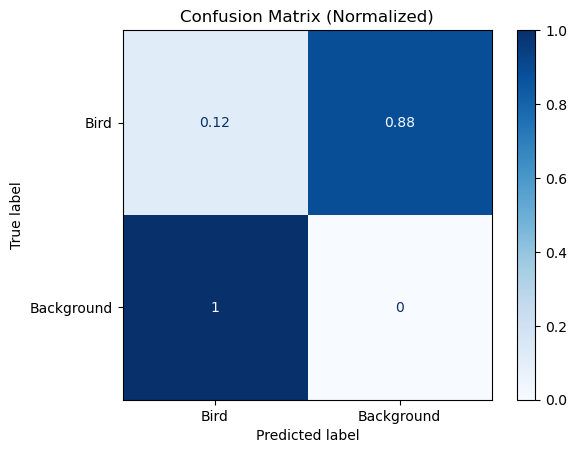

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Definir la matriz de confusión con los valores dados
'''cm = np.array([[54.9, 45.09],
               [100, 0]])'''

cm = np.array([[13, 100],
               [86.99, 0]])

# Normalizar la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Asegurar que el valor mínimo sea 0
cm_normalized = np.nan_to_num(cm_normalized)

# Crear el display de la matriz de confusión normalizada
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Bird', 'Background'])

# Configurar la figura
plt.figure(figsize=(8, 6))

# Dibujar la matriz de confusión con cmap 'Blues'
disp_normalized.plot(cmap='Blues')

# Aumentar el tamaño de las celdas y ajustar los colores del texto

# Título de la matriz
plt.title('Confusion Matrix (Normalized)')

# Mostrar la figura
plt.show()


In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.metrics import confusion_matrix
import seaborn as sns

def calculate_metrics_and_logistic_regression(ground_truth_path, predictions_dir, iou_threshold=0.2, conf_threshold=0.7):
    ground_truth = pd.read_csv(ground_truth_path)
    predicciones = {}
    WIDTH = 930
    audio_duration_sec = 60
    for f in listdir(predictions_dir):
        with open(join(predictions_dir, f), 'r') as file:
            lines = file.readlines()
            predicciones[f.replace('.txt', '.WAV')] = [line.strip().split() for line in lines]

    TP, FP, FN = 0, 0, 0
    X, Y = [], []

    for index, row in ground_truth.iterrows():
        archivo_gt = row['path']
        archivo_gt_basename = archivo_gt.split('/')[-1]
        inicio_gt = row['start_time']
        fin_gt = row['end_time']
        encontrado = False

        if archivo_gt_basename in predicciones:
            for pred in predicciones[archivo_gt_basename]:
                _, x_center, _, width, _, score = map(float, pred)
                x_center_desnorm = x_center * WIDTH
                width_desnorm = width * WIDTH
                start_sec = (x_center_desnorm - width_desnorm / 2) * 60 / WIDTH
                end_sec = (x_center_desnorm + width_desnorm / 2) * 60 / WIDTH
                start_sec = max(0, min(start_sec, audio_duration_sec))
                end_sec = max(0, min(end_sec, audio_duration_sec))
                iou = calculate_iou((inicio_gt, fin_gt), (start_sec, end_sec))
                if iou > iou_threshold:
                    encontrado = True
                    TP += 1
                    X.append(score)
                    Y.append(1)  # Correct detection
                    break
            if not encontrado:
                FN += 1
                X.append(score)
                Y.append(0)
        else:
            FN += 1

    for filename, preds in predicciones.items():
        for pred in preds:
            _, x_center, _, width, _, score = map(float, pred)
            x_center_desnorm = x_center * WIDTH
            width_desnorm = width * WIDTH
            start_sec = (x_center_desnorm - width_desnorm / 2) * 60 / WIDTH
            end_sec = (x_center_desnorm + width_desnorm / 2) * 60 / WIDTH
            start_sec = max(0, min(start_sec, audio_duration_sec))
            end_sec = max(0, min(end_sec, audio_duration_sec))
            if not any(calculate_iou((inicio_gt, fin_gt), (start_sec, end_sec)) > 0.5 for inicio_gt, fin_gt in zip(ground_truth['start_time'], ground_truth['end_time']) if ground_truth['path'].str.contains(filename).any()):
                FP += 1
                X.append(score)
                Y.append(0)  # Incorrect detection

    print(f"TP: {TP}, FP: {FP}, FN: {FN}")

    # Matriz de confusión
    cm = confusion_matrix(Y, [1 if x > conf_threshold else 0 for x in X])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.show()

    # Regresión logística
    modelo = LogisticRegression()
    modelo.fit(np.array(X).reshape(-1, 1), Y)
    X_test = np.linspace(min(X), max(X), 300)
    plt.scatter(X, Y, color='black')
    plt.plot(X_test, modelo.predict_proba(X_test.reshape(-1, 1))[:, 1], color='blue', linewidth=3)
    plt.title('Regresión Logística')
    plt.xlabel('Score de la Predicción')
    plt.ylabel('Probabilidad de Detección Correcta')
    plt.show()

# Uso de la función
calculate_metrics_and_logistic_regression('../Data/Dataset/CSVs/validation_with_bg.csv', '../runs/detect/predict__val_model11_conf0/labels', iou=0.2, conf_threshold=0.1)

KeyboardInterrupt: 

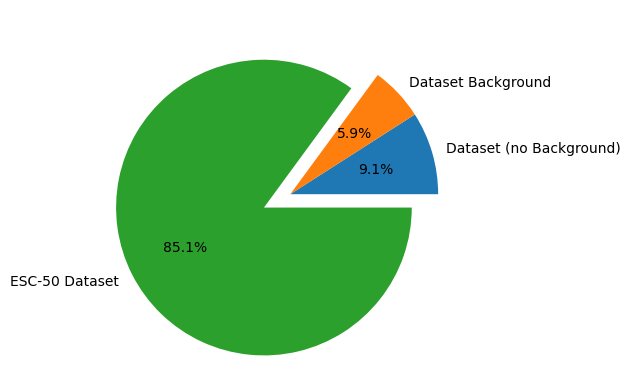

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el dataset 1:
dataset1 = pd.read_csv('../Data/Dataset/CSVs/train_with_bg.csv')

# Asumiendo que dataset2 es un archivo CSV, podrías necesitar ajustar el método de lectura si no lo es.
dataset2 = pd.read_csv('../ESC-50/meta/train_background.txt', header=None)

# Filtrar dataset1 para obtener solo aquellos registros que no son "No audio"
dataset1_no_audio = dataset1[dataset1['specie'] == 'No audio']
dataset1_birds = dataset1[dataset1['specie'] != 'No audio']

# Tomar rutas únicas de dataset1 para "No audio" y otros
dataset1_no_audio_paths = dataset1_no_audio['path'].unique()
dataset1_birds_paths = dataset1_birds['path'].unique()

explode = (0, 0, 0.2)  # Resalta la segunda rebanada si lo deseas

# Graficar un gráfico de pastel de la longitud de cada conjunto de datos
fig, ax = plt.subplots(facecolor='none')  # Establecer el fondo del gráfico para que sea transparente
ax.pie([len(dataset1_birds_paths), len(dataset1_no_audio_paths), len(dataset2)], explode=explode, labels=['Dataset (no Background)', 'Dataset Background', 'ESC-50 Dataset'], autopct='%1.1f%%')
ax.set_facecolor('none')  # Establecer el fondo de los ejes para que sea transparente
plt.show()

# Para guardar la figura con un fondo transparente
# fig.savefig('pie_chart_transparent_background.png', transparent=True)